In [1]:
import polars as pl

# import torch
from pathlib import Path

import umap
import hdbscan
import nltk
import pickle
import os

from bertopic import BERTopic
from collections import defaultdict
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from matplotlib import pyplot as plt

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/jupyterhub-
[nltk_data]     users/sshabayek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# torch.cuda.is_available()
# https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html#training

## Utils

In [4]:
def get_topic_model(docs, model_name, min_cluster_size):

    sentence_model = SentenceTransformer(model_name)
    embeddings = sentence_model.encode(docs, how_progress_bar=False)
    vectorizer_model = CountVectorizer(stop_words=get_stop_words(), min_df=2, ngram_range=(1, 3))

    # reduce embeddings dimension
    umap_model = umap.UMAP(n_neighbors=20, n_components=10, min_dist=0.0, metric="cosine", low_memory=False)

    """perform documents clustering"""
    hdbscan_model = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=1,
        metric="euclidean",
        cluster_selection_method="eom",
        prediction_data=True,
    )

    topic_model = BERTopic(
        # Pipeline models
        embedding_model=sentence_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        # Hyperparameters
        top_n_words=10,
        verbose=True,
    )
    """
    if save:
        topic_model.save(
        model_title = model_title,
        serialization="safetensors",
        save_ctfidf=True
    )
    #my_model = BERTopic.load("my_model")
    """
    """ Train model"""
    topics, probs = topic_model.fit_transform(docs, embeddings)

    return topic_model, embeddings, topics, probs

In [5]:
def clean_df(df, var):

    df = df.with_columns(foo_lower=pl.col(var).str.to_lowercase())
    df1 = df.unique(subset=[var], keep="first")

    return df1

In [6]:
def drop_words(phrase):

    list_stop = [
        "ton",
        "de",
        "les",
        "et",
        "le",
        "la",
        "que",
        "un",
        "je",
        "c'est",
        "quand",
        "cest",
        "si",
        "comme",
        "bonjour",
        "un",
        "il",
        "je",
        "to",
        "the",
        "of",
        "for",
        "et",
        "une",
        "un",
        "de" "est",
    ]

    disallowed_wordlist = stopwords.words("french") + list_stop

    phrase_split = phrase.split()

    allowed_words_list = []

    for word in phrase_split:

        if word not in disallowed_wordlist:

            allowed_words_list.append(word)

    new_phrase = " ".join(allowed_words_list)

    return new_phrase

In [7]:
def get_stop_words():
    list_stop = [
        "ton",
        "de",
        "les",
        "et",
        "le",
        "la",
        "que",
        "un",
        "je",
        "c'est",
        "quand",
        "cest",
        "si",
        "comme",
        "bonjour",
        "un",
        "il",
        "to",
        "the",
        "of",
        "for",
        "une",
        "un",
        "de" "est",
        "ne",
    ]

    list_stop_words = stopwords.words("french") + list_stop

    return list_stop_words

In [8]:
def plot_categories(df, topic_model, model_name, figure_name, save):

    topics = topic_model.get_topic_info()

    print("there are ", len(topics), " topics, when I use the model ", model_name)
    topics = topics[topics["Topic"].isin(range(0, 100))]
    N = len(topics)

    legende = []
    legende_dict = {}

    for i in range(0, N):
        legende.append("Topic " + str(i) + ": " + ", ".join(topics["Representation"].iloc[i][:9]))
        legende_dict[i] = "Topic " + str(i) + ": " + ", ".join(topics["Representation"].iloc[i][:9])

    var1 = "Topic"
    df_pl = df[["Topic"]].sort_values(by=var1)
    df_pl = df.groupby([var1], as_index=False)[var1].count().fillna(0)
    df_pl["count"] = df_pl.sum(axis=1)
    df_pl = df_pl.sort_values(by="count", ascending=False).drop(columns=["count"])
    plt.figure(figsize=(8, N / 4))

    ax = df_pl.plot(kind="barh", stacked=True, figsize=(12, N / 4), colormap=plt.cm.tab20)
    plt.title(model_name)
    plt.yticks(range(N), map(lambda x: legende_dict[x], range(N)))
    plt.legend()
    plt.margins(0.04, 0)
    if save:
        plt.savefig(figure_name, bbox_inches="tight", dpi=600)

## Process data

In [9]:
votes_path = Path(".").resolve().parent / "data" / "votes.parquet"
votes = pl.read_parquet(votes_path)
df = clean_df(votes, "opening_msg")
print("Number of unique observations / documents :", len(df))

Number of unique observations / documents : 42454


In [10]:
docs = df["opening_msg"].to_list()
# docs_stopwords = [drop_words(x) for x in docs]

## Step 1: Get topics with BerTopic

In [11]:
list_models = ["sentence-transformers/roberta-base-nli-stsb-mean-tokens"]
min_cluster_size = 50
for model in list_models:
    topic_model, embeddings, topics, probs = get_topic_model(
        docs,
        model,
        min_cluster_size,
    )

2025-07-31 18:45:52,875 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-31 18:46:22,452 - BERTopic - Dimensionality - Completed ✓
2025-07-31 18:46:22,453 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-31 18:46:27,225 - BERTopic - Cluster - Completed ✓
2025-07-31 18:46:27,232 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-31 18:46:32,335 - BERTopic - Representation - Completed ✓


In [12]:
# topic_model = BERTopic.load(path=f"../data/bertopic_july_20")

In [13]:
df1 = topic_model.get_document_info(docs).sort_values(by="Topic")

In [14]:
df1["Topic"].value_counts()

Topic
-1      23958
 0       1125
 1        828
 2        559
 3        510
        ...  
 122       52
 123       52
 124       51
 125       50
 126       50
Name: count, Length: 128, dtype: int64

there are  128  topics, when I use the model  BertTopic


<Figure size 800x2500 with 0 Axes>

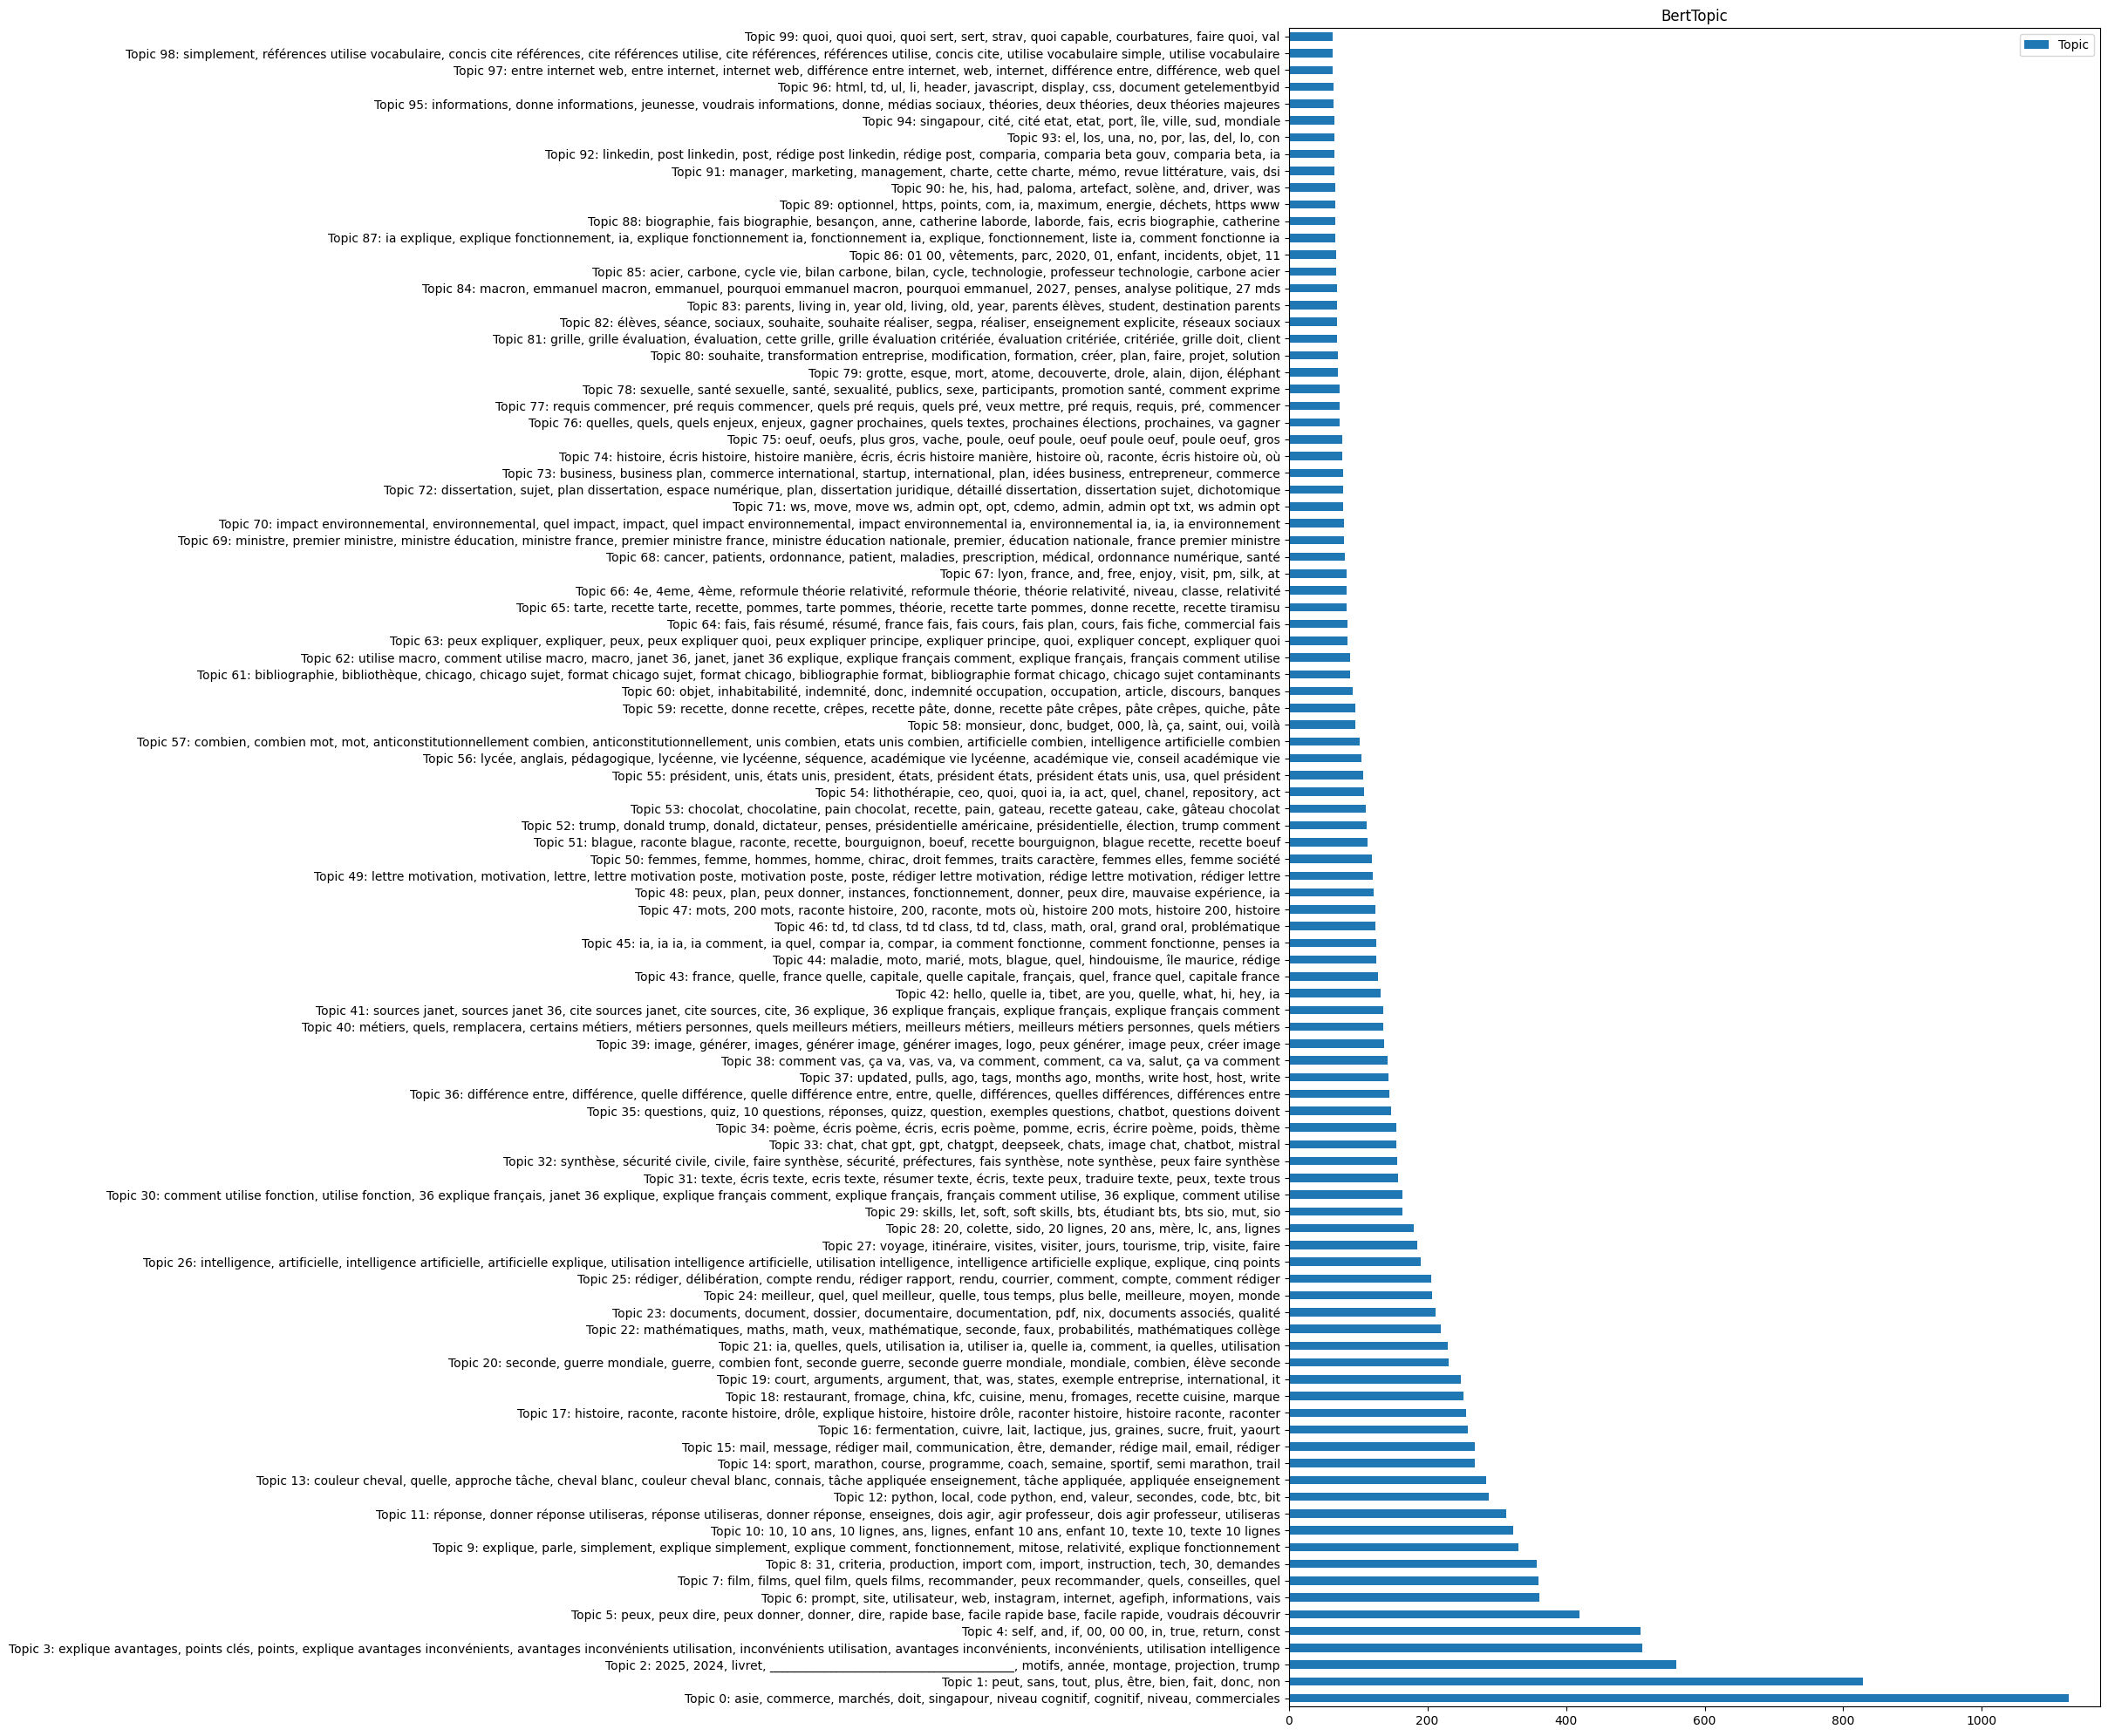

In [15]:
plot_categories(df1[df1["Topic"].isin(range(0, 100))], topic_model, "BertTopic", "../figures/topics_bert.jpg", True)

In [16]:
hierarchical_topics = topic_model.hierarchical_topics(docs)


00%|██████████| 126/126 [00:00<00:00, 248.98it/s]

In [17]:
fig = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [18]:
fig

In [19]:
fig.write_html("../figures/dendogram.html")

In [20]:
plt.savefig("../figures/dendogram.jpg", bbox_inches="tight", dpi=600)

<Figure size 640x480 with 0 Axes>

## Step 2 : sampling of most relevant documents

#### Sampling : this part was copied from the Arena Explorer notebook 

In [21]:
doc = docs
sampled_prompts = defaultdict(list)
topic_info = topic_model.get_topic_info()
doc_info = topic_model.get_document_info(doc)

for topic_id in topic_info["Topic"][1:]:
    filtered_docs = doc_info[
        (doc_info["Topic"] == topic_id)
        & (doc_info["Probability"] >= doc_info["Probability"].quantile(0.8))
        & (doc_info["Document"].str.split().str.len() >= 5)
    ]

    res = filtered_docs
    cap = 100
    if len(filtered_docs) >= 20:
        while len(res) < 20:
            res = filtered_docs[filtered_docs["Document"].str.split().str.len() <= cap]
            cap += 50

    sampled_docs = res.sample(n=min(20, len(res)), random_state=42, replace=False)

    sampled_prompts[topic_id] = sampled_docs["Document"].tolist()

In [22]:
save_path = "../data"

with open(f"{save_path}/example_prompts.pkl", "wb") as f:
    pickle.dump(sampled_prompts, f)

In [23]:
new_topics = topic_model.reduce_outliers(list(doc), topics, strategy="c-tf-idf", threshold=0.1)
new_topics = topic_model.reduce_outliers(list(doc), new_topics, strategy="distributions")
topic_model.update_topics(doc, topics=new_topics)


2025-07-31 18:47:34,934 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [24]:
topic_info = topic_model.get_topic_info()
doc_info = topic_model.get_document_info(docs)
topic_info[topic_info["Topic"].isin(range(0, 30))]

,Topic,Count,Name,Representation,Representative_Docs
1,0,1340,0_les_asie_de_des,"[les, asie, de, des, commerce, la, et, dans, s...",[Tu es le meilleur enseignant du monde pour gé...
2,1,2587,1_il_pas_est_que,"[il, pas, est, que, le, la, qui, on, ne, et]",[Trouve moi une problématique en fonction de s...
3,2,720,2_2025_2024_eur_en,"[2025, 2024, eur, en, de, du, année, le, et, 000]","[Qui est le président en 2025, en France ?, me..."
4,3,662,3_avantages_inconvénients_points_clés,"[avantages, inconvénients, points, clés, pour,...",[Explique les avantages et inconvénients de l'...
5,4,779,4_the_and_00_in,"[the, and, 00, in, to, of, if, for, self, this]",[import tkinter as tk\nfrom tkinter import fil...
6,5,1214,5_peux_me_tu_donner,"[peux, me, tu, donner, dire, proposer, je, bon...",[Je voudrais découvrir une recette facile et r...
7,6,740,6_site_prompt_utilisateur_web,"[site, prompt, utilisateur, web, pour, informa...","[En tant que prompt Engineer, peux tu proposer..."
8,7,476,7_film_films_vitrage_conseilles,"[film, films, vitrage, conseilles, me, tempéra...","[Si j'ai aimé le film Contact, quels autres fi..."
9,8,1143,8_des_et_les_de,"[des, et, les, de, test, cas, du, la, pour, en]",[Instructions pour l'IA : Création d'un Script...
10,9,948,9_explique_moi_parle_concept,"[explique, moi, parle, concept, simplement, co...","[Explique moi la lithothérpie, explique moi dr..."


## Step 3: summarize each topic using an LLM